# Домашнее задание:
1) взять данные отсюда: https://github.com/Laggg/data--for--students (flight_delays.csv)

Задача: научиться предсказывать задержку (столбик *dep_delayed_15min*) рейса по имеющимся данным с помощью Дерева решений (или других алгоритмов).
Это задача бинарной классификации (будет/не будет задержка). Улучшить приведенный пример.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')


import itertools
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

def plot_confusion_matrix(targets,predictions,classes,
                          normalize=False,title='Confusion matrix',
                          figsize=(4, 4), cmap=plt.cm.Reds):

    conf_matrix = confusion_matrix(y_true=targets, y_pred=predictions)

    if normalize:
        conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title.lower()

    plt.figure(figsize=figsize)
    plt.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_matrix.max() / 2.
    for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):

        if normalize:
            value = '{} %'.format(format(conf_matrix[i, j] * 100, '.2f'))
        else:
            value = format(conf_matrix[i, j], fmt)

        plt.text(j,i,value,horizontalalignment="center",color="white" if conf_matrix[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()

In [2]:
path_to_file = 'flight_delays.csv'
data = pd.read_csv(path_to_file)
data.head(10)

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y
5,c-8,c-3,c-4,1918,NW,MEM,MCO,683,N
6,c-1,c-27,c-4,754,DL,PBI,LGA,1035,N
7,c-4,c-29,c-6,635,OH,MSP,CVG,596,N
8,c-7,c-28,c-5,735,AA,ONT,DFW,1189,N
9,c-6,c-20,c-2,2029,OO,DEN,PSC,853,N


In [3]:
# Отделим столбик-таргет от признаков:
target = (data['dep_delayed_15min'] == 'Y').astype(int)

data = data.drop(['dep_delayed_15min'], axis=1)
data.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732
1,c-4,c-20,c-3,1548,US,PIT,MCO,834
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423


In [19]:
# возьмем несколько столбцов данных как признаки, по которым будем предсказывать:
X = data[['DepTime','Distance', 'Month']]
X['DepTime'] = X['DepTime']//100
X['Month'] = X['Month'].apply(lambda x: int(x[2:]))
for i in range(100000):
    if X['DepTime'].iloc[i] == 24:
        X['DepTime'].iloc[i] = 0
    if X['DepTime'].iloc[i] == 25:
        X['DepTime'].iloc[i] = 1
    
X.head()

,DepTime,Distance,Month
0,19,732,8
1,15,834,4
2,14,416,9
3,10,872,11
4,18,423,10


In [20]:
DayOfWeek = data['DayOfWeek'].apply(lambda x: int(x[2:]))
DayofMonth = data['DayofMonth'].apply(lambda x: int(x[2:]))

In [21]:
onehot_encoder = OneHotEncoder(sparse = False)
Carrier = pd.DataFrame(onehot_encoder.fit_transform(np.array(data['UniqueCarrier']).reshape(-1, 1)))

In [22]:
X =  pd.concat([X,Carrier,DayOfWeek,DayofMonth], axis=1, sort=False)

In [23]:
# разделим выборку на обучающую и тестовую(валидационную, проверочную, отложенная)
x_train, x_test, y_train, y_test = train_test_split(X, target, test_size=0.1, random_state=42)

# обучим модель дерева на обучающей выборке и предскажем на отложенной:
model = DecisionTreeClassifier(max_depth=40, min_samples_split=2)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

Общее число совпадений 0.7257
Полнота охвата класса 1: 0.3064935064935065
Точность: 0.2952952952952953


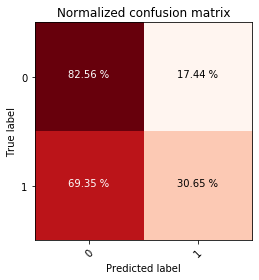

In [24]:
# матрица ошибок алгоритма. При хорошем прогнозе на главной диагонали будут стоять цифры, близкие к 100.
print('Общее число совпадений', accuracy_score(y_test, y_pred))
print('Полнота охвата класса 1:', recall_score(y_test, y_pred))
print('Точность:', precision_score(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred, [0,1], normalize=True)

подсказка - для работы с категориальными признаками прочитайте про Label Encoder и OneHot Encoder

дедлайн - через неделю, 19.05.2020. Удачи!)